In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.ndimage import label
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

MAX_STEPS = 10

def generate_percolation_lattice(size, p):
    return np.random.choice([0, 1], (size, size), p=[1-p, p]).astype(np.uint8)

def check_percolation(lattice):
    labeled, _ = label(lattice)
    top = set(labeled[0]) - {0}
    bottom = set(labeled[-1]) - {0}
    left = set(labeled[:,0]) - {0}
    right = set(labeled[:,-1]) - {0}
    return float(bool(top & bottom) or bool(left & right))

def first_coarse_graining(binary_lattice, dim):
    """Average non-overlapping dim×dim blocks."""
    t = torch.tensor(binary_lattice, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    patches = F.unfold(t, kernel_size=dim, stride=dim)             # [1, dim*dim, num_patches]
    patches = patches.permute(0, 2, 1)                             # [1, num_patches, dim*dim]
    coarse_vals = patches.mean(dim=2)                             # [1, num_patches]
    H, W = binary_lattice.shape
    new_h, new_w = H // dim, W // dim
    return coarse_vals.view(1, 1, new_h, new_w).squeeze(0)        # [1, new_h, new_w]

class PercolationModel(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.rule = nn.Sequential(
            nn.Linear(dim * dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, max_steps=MAX_STEPS):
        b, c, H, W = x.shape
        for _ in range(max_steps):
            if H < self.dim or W < self.dim:
                break
            patches = F.unfold(x, kernel_size=self.dim, stride=self.dim)  # [b, dim*dim, np]
            patches = patches.permute(0, 2, 1).contiguous()               # [b, np, dim*dim]
            out = self.rule(patches.view(-1, self.dim*self.dim))          # [b*np, 1]
            new_h, new_w = H // self.dim, W // self.dim
            x = out.view(b, 1, new_h, new_w)
            _, _, H, W = x.shape
        return x.squeeze(1).view(b, -1)  # returns shape [b, new_h*new_w] or [b] if fully reduced

def prepare_dataset(N, sizes):
    data = []
    for _ in tqdm(range(int(N/2)), desc="Generating data"):
        p = np.random.uniform(0.1, 0.9)
        size = np.random.choice(sizes)
        L = generate_percolation_lattice(size, p)
        data.append((L, check_percolation(L)))
    for _ in tqdm(range(int(N/2)), desc="Generating fractal data"):
        p = np.random.uniform(0.55, 0.65)
        size = np.random.choice(sizes)
        L = generate_percolation_lattice(size, p)
        data.append((L, check_percolation(L)))
    return data

def train_epoch(model, device, data, batch_size, opt, crit, dim):
    model.train()
    total_loss = 0.0
    
    for i in tqdm(range(0, len(data), batch_size), desc="Training"):
        batch = data[i:i+batch_size]
        processed = []
        
        # Apply first coarse-graining
        for x, y in batch:
            cg_lattice = first_coarse_graining(x, dim)
            h, w = cg_lattice.shape[-2], cg_lattice.shape[-1]
            processed.append((cg_lattice, y, (h, w)))
        
        # Group by size
        groups = {}
        for cg, y, size in processed:
            if size not in groups:
                groups[size] = []
            groups[size].append((cg, y))
        
        # Process each group
        group_loss = 0.0
        for size_key, group in groups.items():
            lattices = [item[0] for item in group]
            labels = [item[1] for item in group]
            inputs = torch.stack(lattices).to(device)
            targets = torch.tensor(labels, dtype=torch.float32, device=device)
            
            opt.zero_grad()
            outputs = model(inputs)
            loss = crit(outputs.view(-1), targets)
            loss.backward()
            opt.step()
            group_loss += loss.item() * len(group)
        
        total_loss += group_loss
    
    return total_loss / len(data)




In [2]:
# ----------------- Run -----------------
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Configuration
DIM = 6      # Patch size for coarse-graining
POWER = 3    # Base exponent for lattice sizes
SIZES = [DIM**2, DIM**3, DIM**4]  # Mixed training sizes
EPOCHS = 15  # Number of training epochs
BATCH_SIZE = 10

# Generate datasets
train_data = prepare_dataset(10_000, SIZES)
test_data = prepare_dataset(1000, SIZES)

# Initialize model
model = PercolationModel(DIM).to(DEVICE)
opt = optim.Adam(model.parameters(), lr=1e-3)
crit = nn.BCELoss()


def evaluate_model(model, device, data, batch_size, crit, dim):
    """Evaluate model on test dataset and return average loss"""
    model.eval()
    total_loss = 0.0
    
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        processed = []
        
        # Apply first coarse-graining
        for x, y in batch:
            cg_lattice = first_coarse_graining(x, dim)
            h, w = cg_lattice.shape[-2], cg_lattice.shape[-1]
            processed.append((cg_lattice, y, (h, w)))
        
        # Group by size
        groups = {}
        for cg, y, size in processed:
            if size not in groups:
                groups[size] = []
            groups[size].append((cg, y))
        
        # Process each group
        for size_key, group in groups.items():
            lattices = [item[0] for item in group]
            labels = [item[1] for item in group]
            inputs = torch.stack(lattices).to(device)
            targets = torch.tensor(labels, dtype=torch.float32, device=device)
            
            with torch.no_grad():
                outputs = model(inputs)
                loss = crit(outputs.view(-1), targets)
                total_loss += loss.item() * len(group)
    
    return total_loss / len(data)

# Training loop with loss tracking
for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss = train_epoch(model, DEVICE, train_data, BATCH_SIZE, opt, crit, DIM)
    
    # Evaluate on test set
    test_loss = evaluate_model(model, DEVICE, test_data, BATCH_SIZE, crit, DIM)
    
    print(f"Epoch {epoch}/{EPOCHS} — Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Training: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:41<00:00, 23.86it/s]


Epoch 1/15 — Train Loss: 0.5453, Test Loss: 0.3261


Training: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:40<00:00, 24.58it/s]


Epoch 2/15 — Train Loss: 0.3185, Test Loss: 0.2283


Training: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:46<00:00, 21.39it/s]


Epoch 3/15 — Train Loss: 0.3285, Test Loss: 0.2279


Training: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.32it/s]


Epoch 4/15 — Train Loss: 0.2901, Test Loss: 0.5147


Training: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 23.10it/s]


Epoch 5/15 — Train Loss: 0.2833, Test Loss: 0.3784


Training: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.33it/s]


Epoch 6/15 — Train Loss: 0.2785, Test Loss: 0.3322


Training: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.24it/s]


Epoch 7/15 — Train Loss: 0.3005, Test Loss: 0.3186


Training: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 23.08it/s]


Epoch 8/15 — Train Loss: 0.2786, Test Loss: 0.3655


Training: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.87it/s]


Epoch 9/15 — Train Loss: 0.2644, Test Loss: 0.5776


Training: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.79it/s]


Epoch 10/15 — Train Loss: 0.2750, Test Loss: 0.2311


Training: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:41<00:00, 24.02it/s]


Epoch 11/15 — Train Loss: 0.2924, Test Loss: 0.2866


Training: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 25.95it/s]


Epoch 12/15 — Train Loss: 0.2760, Test Loss: 0.7620


Training: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.66it/s]


Epoch 13/15 — Train Loss: 0.2716, Test Loss: 0.2283


Training: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.83it/s]


Epoch 14/15 — Train Loss: 0.2690, Test Loss: 0.3010


Training: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 21.09it/s]


Epoch 15/15 — Train Loss: 0.2692, Test Loss: 0.2960


k=2 (L=36):   0%|                                                                                          | 0/3000 [00:00<?, ?it/s]C:\Users\lucac\AppData\Local\Temp\ipykernel_9208\3992270051.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cg_tensor = torch.tensor(cg, dtype=torch.float32).unsqueeze(0).to(DEVICE)
k=5 (L=7776): 100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [08:54<00:00,  5.62it/s]


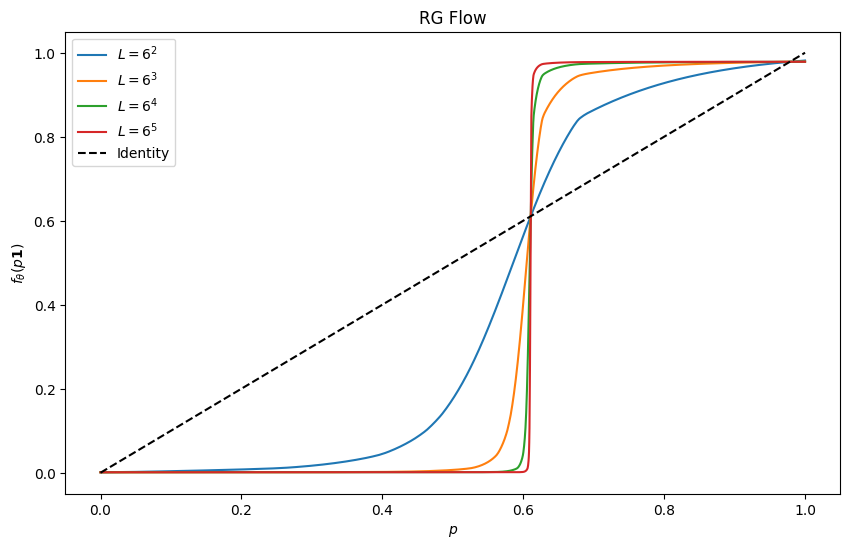

In [3]:
# Configuration
k_list = [2, 3, 4, 5]  # Exponents: L = 9, 27, 81, 243, 729
p_values = np.linspace(0, 1, 3000)
results = {k: [] for k in k_list}
DIM = 6

for k in k_list:
    L = DIM**k
    # Create uniform lattice of value p (not random binary!)
    for p in tqdm(p_values, desc=f"k={k} (L={L})"):
        # Create uniform tensor filled with p
        uniform_lattice = torch.full((1, 1, L, L), p, dtype=torch.float32, device=DEVICE)
        
        # Apply first coarse-graining (averaging)
        cg = first_coarse_graining(uniform_lattice.squeeze().cpu().numpy(), DIM)
        cg_tensor = torch.tensor(cg, dtype=torch.float32).unsqueeze(0).to(DEVICE)
        
        # Pass through model
        with torch.no_grad():
            output = model(cg_tensor).squeeze().item()
        results[k].append(output)

# Plot RG flow
plt.figure(figsize=(10, 6))
for k in k_list:
    plt.plot(p_values, results[k], label=f"$L={DIM}^{k}$")
plt.plot(p_values, p_values, 'k--', label="Identity")
plt.xlabel("$p$")
plt.ylabel(r"$f_{\theta}(p\mathbf{1})$")
plt.title("RG Flow")
plt.legend()
plt.savefig("rg_flow_uniform_p.png")
plt.show()

Analyzing learned rule: 100%|█████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 9636.02it/s]


Estimated p_c = 0.610584
Derivative at p_c: dR/dp = 4.307806
Critical exponent ν = 1.226872


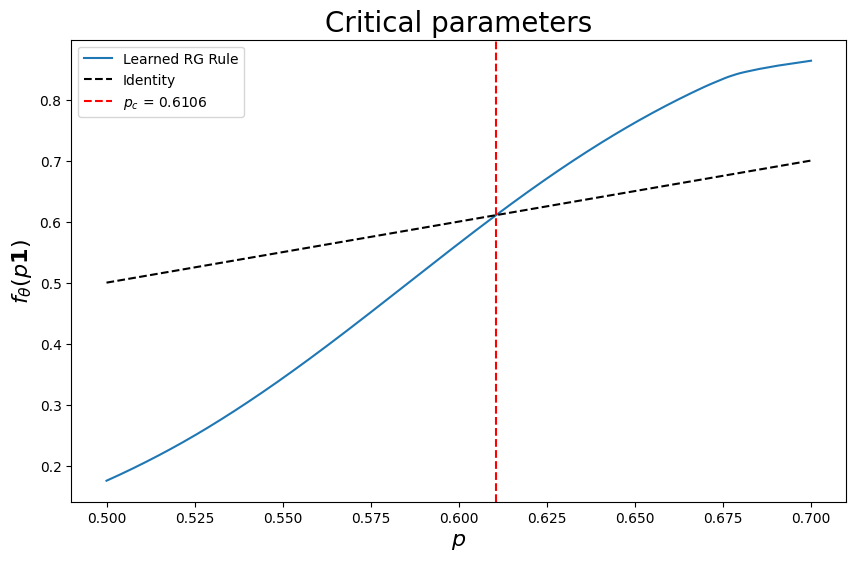

In [4]:
# Analyze the learned RG rule directly on uniform 3x3 blocks
p_values_single = np.linspace(0.5, 0.7, 3000)  # Focus on critical region
R_single = []
DIM = 6

# Create uniform 3x3 blocks (9 values per block)
for p in tqdm(p_values_single, desc="Analyzing learned rule"):
    input_tensor = torch.ones(1, DIM**2, device=DEVICE) * p
    with torch.no_grad():
        output = model.rule(input_tensor).squeeze().item()
    R_single.append(output)

# Find fixed point (where R(p) = p)
crossing_idx = np.where(np.diff(np.sign(np.array(R_single) - p_values_single)))[0]
if crossing_idx.size > 0:
    idx = crossing_idx[0]
    p_c = p_values_single[idx] + (p_values_single[idx+1] - p_values_single[idx]) * \
          (0 - (R_single[idx] - p_values_single[idx])) / \
          ((R_single[idx+1] - p_values_single[idx+1]) - (R_single[idx] - p_values_single[idx]))
else:
    p_c = 0.5927  # Fallback to known value

# Compute derivative at p_c using automatic differentiation
p_tensor = torch.tensor([p_c], requires_grad=True, dtype=torch.float32, device=DEVICE)
input_tensor = torch.ones(1, DIM**2, device=DEVICE) * p_tensor
output = model.rule(input_tensor)
output.backward()
dRdp = p_tensor.grad.item()

# Critical exponent (b = scale factor = 3)
b = DIM
nu = np.log(b) / np.log(dRdp)

print(f"Estimated p_c = {p_c:.6f}")
print(f"Derivative at p_c: dR/dp = {dRdp:.6f}")
print(f"Critical exponent ν = {nu:.6f}")

# Plot the learned rule and fixed point
plt.figure(figsize=(10, 6))
plt.plot(p_values_single, R_single, label="Learned RG Rule")
plt.plot(p_values_single, p_values_single, 'k--', label="Identity")
plt.axvline(p_c, color='r', linestyle='--', label=f"$p_c$ = {p_c:.4f}")
plt.xlabel("$p$", fontsize=16)
plt.ylabel(r"$f_{\theta}(p\mathbf{1})$", fontsize=16)
plt.title("Critical parameters", fontsize=20)
plt.legend()
plt.savefig("learned_rule.png")
plt.show()

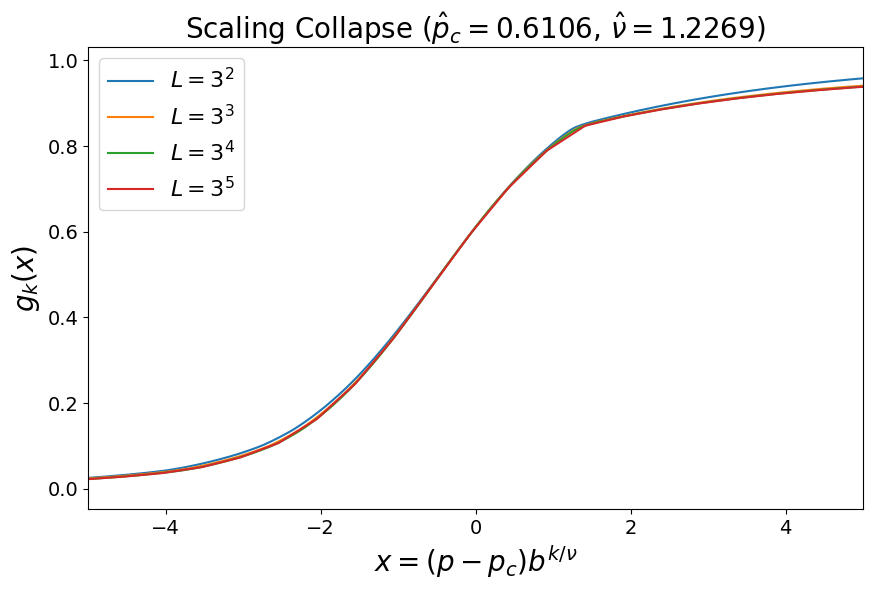

In [5]:
DIM = 6
plt.figure(figsize=(10, 6))
for k in k_list:
    L = DIM**k
    # Rescaled variable: x = (p - p_c) * L^(1/ν)
    x = (p_values - p_c) * (L ** (1/nu))
    plt.plot(x, results[k], label=f"$L=3^{k}$")

plt.xlabel(r"$x=(p - p_c) b^{k/\nu}$", fontsize=20)
plt.ylabel("$g_k(x)$", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f"Scaling Collapse ($\\hat{{p}}_c={p_c:.4f}$, $\\hat{{\\nu}}={nu:.4f}$)", fontsize=20)
plt.xlim(-5, 5)  # Focus on critical region
plt.legend(fontsize=16)  # Increased from 12 to 14
plt.savefig("scaling_collapse.png")
plt.show()